In [45]:
!mkdir data
!wget http://imgcom.jsrt.or.jp/imgcom/wp-content/uploads/2019/07/Segmentation01_RGB.zip -P data/
!unzip data/Segmentation01_RGB.zip -d data/

mkdir: cannot create directory ‘data’: File exists
--2024-02-26 00:58:59--  http://imgcom.jsrt.or.jp/imgcom/wp-content/uploads/2019/07/Segmentation01_RGB.zip
Resolving imgcom.jsrt.or.jp (imgcom.jsrt.or.jp)... 158.199.228.161
Connecting to imgcom.jsrt.or.jp (imgcom.jsrt.or.jp)|158.199.228.161|:80... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-02-26 00:59:00 ERROR 404: Not Found.

Archive:  data/Segmentation01_RGB.zip
replace data/__MACOSX/._Segmentation01_RGB? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [46]:
!pip install pydicom

In [192]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import os
from PIL import Image
import numpy as np
import utils
import matplotlib.pyplot as plt

In [224]:
args = {}
args["data_dir"] = "data/Segmentation01_RGB"
args["data"] = "segmentation01"
args["lr"] = 0.001
utils.split_train_to_val(args["data"], args["data_dir"], val_ratio=0.1)

In [225]:
dataloaders, dataset_sizes = utils.get_dataloaders(
            args["data"], args["data_dir"], ["train", "val"]
        )

In [226]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.downsample = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(1, 128, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
            ),
            nn.Sequential(
                nn.Conv2d(128, 64, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
            ),
            nn.Sequential(
                nn.Conv2d(64, 64, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2)
            )
        ])
        self.upsample = nn.ModuleList([
            nn.Sequential(
                nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True),
                nn.Conv2d(64, 64, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
            ),
            nn.Sequential(
                nn.Conv2d(128, 128, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(128, 1, kernel_size=1),
            ),
        ])
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        encoder_outputs = []
        for i, layer in enumerate(self.downsample):
            x = layer(x)
            encoder_outputs.append(x)

        # Decoder (upsampling) with skip connections
        for i, layer in enumerate(self.upsample):
            x = layer(x)
            if i < len(self.upsample) - 1:  # Skip connection for all but last layer
                x = torch.cat([x, encoder_outputs[-(i+2)]], dim=1)  # Concatenate skip connection

        x = self.sigmoid(x)
        return x

In [212]:
def get_device(device_str):
    if device_str == "gpu" and torch.cuda.is_available():
        return torch.device("cuda")
    elif device_str == "cpu":
        return torch.device("cpu")
    elif device_str == "mps" and torch.backends.mps.is_available():
        return torch.device("mps")  # You can modify the GPU index if needed
    else:
        print("Warning: Invalid device option. Using CPU.")
        return torch.device("cpu")
device = get_device("gpu")

In [227]:
model = UNet()
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=args["lr"])
model = model.to(device)

In [214]:
def image_to_arrag(image):
    return image.permute(1, 2, 0).cpu().detach().numpy().astype("float")

In [215]:
images, masks = next(iter(dataloaders["train"]))
print(images.shape, masks.shape)

torch.Size([4, 1, 256, 256]) torch.Size([4, 1, 256, 256])


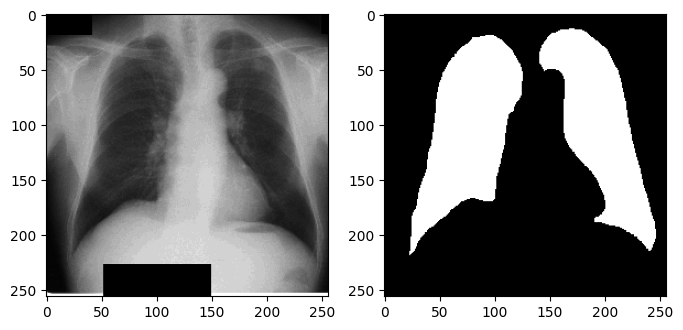

In [216]:
idx = 2
fig=plt.figure(figsize=(8,4))
fig.add_subplot(121)
plt.imshow(image_to_arrag(images[idx]), cmap="gray")
fig.add_subplot(122)
plt.imshow(image_to_arrag(masks[idx]), cmap="gray")
plt.show()

In [201]:
from tqdm import tqdm

In [202]:
from torchsummary import summary
summary(model, (1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 128, 224, 224]           1,280
              ReLU-2        [-1, 128, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          73,792
              ReLU-4         [-1, 64, 224, 224]               0
            Conv2d-5         [-1, 64, 224, 224]          36,928
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
          Upsample-8         [-1, 64, 224, 224]               0
            Conv2d-9         [-1, 64, 224, 224]          36,928
             ReLU-10         [-1, 64, 224, 224]               0
           Conv2d-11        [-1, 128, 224, 224]         147,584
             ReLU-12        [-1, 128, 224, 224]               0
           Conv2d-13          [-1, 1, 224, 224]             129
          Sigmoid-14          [-1, 1, 2

In [228]:
def train_model(model, loss_fn, optimizer, dataloaders, dataser_sizes, num_epochs, mode):
    model.train()
    train_losses, val_losses = [], []
    for epoch in range(num_epochs):
        for phase in ["train", "val"]:
            if phase=="train":
                model.train()
            else:
                model.eval()
            running_loss=0.0
            with tqdm(total=len(dataloaders[phase]), desc=f'{phase.capitalize()} Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
                for inputs, labels in dataloaders[phase]:
                    inputs, labels = inputs.to(device), labels.to(device)
                    optimizer.zero_grad()
                    with torch.set_grad_enabled(phase=="train"):
                        outputs = model(inputs)
                        loss = loss_fn(outputs, labels)
                        if phase=="train":
                            loss.backward()
                            optimizer.step()
                        running_loss += loss.item()
                    pbar.update(1)
            epoch_loss = running_loss / dataset_sizes[phase]
            if phase=="train":
                train_losses.append(epoch_loss)
            else:
                val_losses.append(epoch_loss)
        print(f"Epoch {epoch+1}/{num_epochs} -> Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

    return model, train_losses, val_losses

model, train_losses, val_losses = train_model(model, loss_fn, optimizer, dataloaders, dataset_sizes, 30, "segmentation")

Val Epoch 1/30: 100%|██████████| 2/2 [00:00<00:00,  6.43batch/s]


Epoch 1/30 -> Train Loss: 0.1518, Val Loss: 0.1864


Val Epoch 2/30: 100%|██████████| 2/2 [00:00<00:00,  8.11batch/s]


Epoch 2/30 -> Train Loss: 0.1150, Val Loss: 0.1555


Val Epoch 3/30: 100%|██████████| 2/2 [00:00<00:00,  7.56batch/s]


Epoch 3/30 -> Train Loss: 0.1061, Val Loss: 0.1497


Val Epoch 4/30: 100%|██████████| 2/2 [00:00<00:00,  8.00batch/s]


Epoch 4/30 -> Train Loss: 0.1114, Val Loss: 0.1531


Val Epoch 5/30: 100%|██████████| 2/2 [00:00<00:00,  7.24batch/s]


Epoch 5/30 -> Train Loss: 0.1062, Val Loss: 0.1430


Val Epoch 6/30: 100%|██████████| 2/2 [00:00<00:00,  5.12batch/s]


Epoch 6/30 -> Train Loss: 0.1037, Val Loss: 0.1392


Val Epoch 7/30: 100%|██████████| 2/2 [00:00<00:00,  7.82batch/s]


Epoch 7/30 -> Train Loss: 0.0975, Val Loss: 0.1339


Val Epoch 8/30: 100%|██████████| 2/2 [00:00<00:00,  7.41batch/s]


Epoch 8/30 -> Train Loss: 0.0929, Val Loss: 0.1415


Val Epoch 9/30: 100%|██████████| 2/2 [00:00<00:00,  8.11batch/s]


Epoch 9/30 -> Train Loss: 0.0957, Val Loss: 0.1309


Val Epoch 10/30: 100%|██████████| 2/2 [00:00<00:00,  7.66batch/s]


Epoch 10/30 -> Train Loss: 0.0888, Val Loss: 0.1296


Val Epoch 11/30: 100%|██████████| 2/2 [00:00<00:00,  7.48batch/s]


Epoch 11/30 -> Train Loss: 0.0903, Val Loss: 0.1310


Val Epoch 12/30: 100%|██████████| 2/2 [00:00<00:00,  8.11batch/s]


Epoch 12/30 -> Train Loss: 0.0881, Val Loss: 0.1191


Val Epoch 13/30: 100%|██████████| 2/2 [00:00<00:00,  5.65batch/s]


Epoch 13/30 -> Train Loss: 0.0880, Val Loss: 0.1213


Val Epoch 14/30: 100%|██████████| 2/2 [00:00<00:00,  7.80batch/s]


Epoch 14/30 -> Train Loss: 0.0852, Val Loss: 0.1559


Val Epoch 15/30: 100%|██████████| 2/2 [00:00<00:00,  7.17batch/s]


Epoch 15/30 -> Train Loss: 0.0906, Val Loss: 0.1247


Val Epoch 16/30: 100%|██████████| 2/2 [00:00<00:00,  7.60batch/s]


Epoch 16/30 -> Train Loss: 0.0839, Val Loss: 0.1224


Val Epoch 17/30: 100%|██████████| 2/2 [00:00<00:00,  7.71batch/s]


Epoch 17/30 -> Train Loss: 0.0834, Val Loss: 0.1220


Val Epoch 18/30: 100%|██████████| 2/2 [00:00<00:00,  7.65batch/s]


Epoch 18/30 -> Train Loss: 0.0788, Val Loss: 0.1120


Val Epoch 19/30: 100%|██████████| 2/2 [00:00<00:00,  7.07batch/s]


Epoch 19/30 -> Train Loss: 0.0836, Val Loss: 0.1417


Val Epoch 20/30: 100%|██████████| 2/2 [00:00<00:00,  5.38batch/s]


Epoch 20/30 -> Train Loss: 0.0892, Val Loss: 0.1259


Val Epoch 21/30: 100%|██████████| 2/2 [00:00<00:00,  8.05batch/s]


Epoch 21/30 -> Train Loss: 0.0838, Val Loss: 0.1147


Val Epoch 22/30: 100%|██████████| 2/2 [00:00<00:00,  7.95batch/s]


Epoch 22/30 -> Train Loss: 0.0772, Val Loss: 0.1076


Val Epoch 23/30: 100%|██████████| 2/2 [00:00<00:00,  7.47batch/s]


Epoch 23/30 -> Train Loss: 0.0763, Val Loss: 0.1214


Val Epoch 24/30: 100%|██████████| 2/2 [00:00<00:00,  8.07batch/s]


Epoch 24/30 -> Train Loss: 0.0776, Val Loss: 0.1004


Val Epoch 25/30: 100%|██████████| 2/2 [00:00<00:00,  7.80batch/s]


Epoch 25/30 -> Train Loss: 0.0768, Val Loss: 0.1049


Val Epoch 26/30: 100%|██████████| 2/2 [00:00<00:00,  6.89batch/s]


Epoch 26/30 -> Train Loss: 0.0745, Val Loss: 0.1056


Val Epoch 27/30: 100%|██████████| 2/2 [00:00<00:00,  5.31batch/s]


Epoch 27/30 -> Train Loss: 0.0719, Val Loss: 0.1054


Val Epoch 28/30: 100%|██████████| 2/2 [00:00<00:00,  7.54batch/s]


Epoch 28/30 -> Train Loss: 0.0673, Val Loss: 0.0986


Val Epoch 29/30: 100%|██████████| 2/2 [00:00<00:00,  7.68batch/s]


Epoch 29/30 -> Train Loss: 0.0701, Val Loss: 0.1016


Val Epoch 30/30: 100%|██████████| 2/2 [00:00<00:00,  7.97batch/s]

Epoch 30/30 -> Train Loss: 0.0683, Val Loss: 0.0988


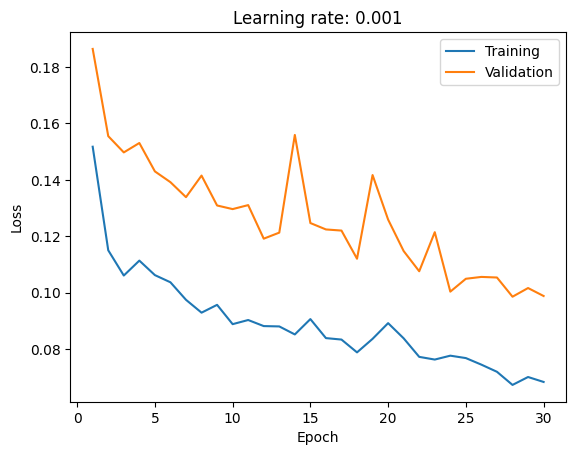

In [229]:
def plot_loss(train_losses, val_losses, learning_rate):
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training")
    plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Learning rate: {learning_rate}")
    plt.legend()
    plt.show()
plot_loss(train_losses, val_losses, args["lr"])

In [230]:
dataloaders, dataset_sizes = utils.get_dataloaders(
            args["data"], args["data_dir"], ["test"]
        )

In [231]:
def test_model(model, loss_fn, dataloader, dataset_size):
    model.eval()
    test_loss = 0.0
    all_outputs = []
    all_targets = []
    all_inputs = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            test_loss += loss.item()
            all_outputs.append(outputs.cpu())
            all_targets.append(labels.cpu())
            all_inputs.append(inputs.cpu())
    test_loss = test_loss / dataset_size
    all_inputs, all_outputs, all_targets = torch.cat(all_inputs), torch.cat(all_outputs), torch.cat(all_targets)
    print(f"Test Loss: {test_loss:.4f}")
    return all_inputs, all_outputs, all_targets
inputs, outputs, targets = test_model(model, loss_fn, dataloaders["test"], dataset_sizes["test"])

Test Loss: 0.1128


In [237]:
def calculate_iou(pred_masks, true_masks, threshold=0.5):
    # Binarize predicted masks based on the threshold
    pred_masks = (pred_masks > threshold).float()

    intersection = torch.sum(pred_masks * true_masks, dim=(2, 3))  # Intersection
    union = torch.sum(pred_masks + true_masks, dim=(2, 3)) - intersection  # Union

    iou = intersection / (union + 1e-8)  # Add epsilon to avoid division by zero
    return torch.mean(iou)
print("mIoU: ", calculate_iou(outputs, targets, 0.5))

mIoU:  tensor(0.6743)


In [238]:
def calculate_dice(pred_masks, true_masks, threshold=0.5):
    # Binarize predicted masks based on the threshold
    pred_masks = (pred_masks > threshold).float()

    intersection = torch.sum(pred_masks * true_masks, dim=(2, 3))  # Intersection
    sum_masks = torch.sum(pred_masks + true_masks, dim=(2, 3))  # Sum of masks

    dice = 2. * intersection / (sum_masks + 1e-8)  # Add epsilon to avoid division by zero
    return torch.mean(dice)
print("mDICE: ", calculate_dice(outputs, targets, 0.5))

mDICE:  tensor(0.7910)


In [232]:
def image_to_arrag(image):
    return image.permute(1, 2, 0).cpu().detach().numpy().astype("float")

In [233]:
outputs=(outputs>0.5).float()

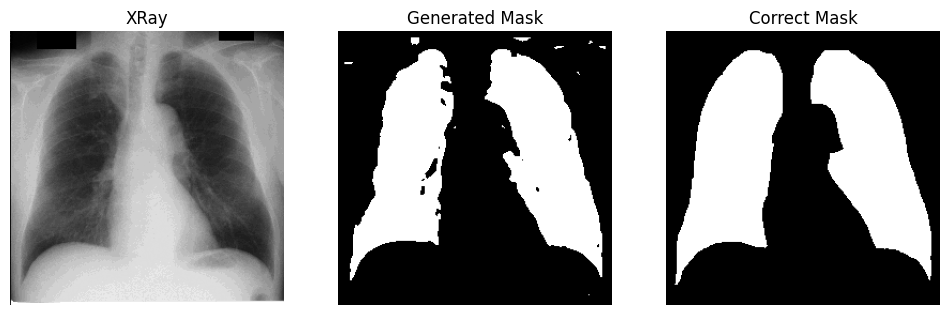

In [242]:
def plot_result(ip, output, target):
    fig = plt.figure(figsize=(12,4))
    fig.add_subplot(131)
    plt.imshow(image_to_arrag(ip), cmap="gray")
    plt.title("XRay")
    plt.axis('off')
    fig.add_subplot(132)
    plt.imshow(image_to_arrag(output), cmap="gray")
    plt.title("Generated Mask")
    plt.axis('off')
    fig.add_subplot(133)
    plt.imshow(image_to_arrag(target), cmap="gray")
    plt.title("Correct Mask")
    plt.axis('off')
    plt.show()
idx=3
plot_result(inputs[idx], outputs[idx], targets[idx])